# Calculate absorption table and nadir OLR spectrum

2020-09-30 Stefan Buehler

Prerequisites: pyarts (for calculation), typhon (here just used in plotting)

If you do not want the sourcecode yourself, you can simply install them with

    pip install pyarts
    pip install typhon
    
If you do want the sourcecode, you can get it for both packages from github: https://github.com/atmtools
    
The absorption lookup table format is described in this paper: https://doi.org/10.1016/j.jqsrt.2011.03.008

You can see documentation for all ARTS variables and methods in the online browser for the built-in documentation:
https://www.radiativetransfer.org/docserver-trunk

On the ARTS webpage (https://www.radiativetransfer.org) there are also pointer to more traditional documentation (User guide, Theory guide, Developer guide). Not all of these are completely up to date, especially the python interface so far is poorly documented.

This demo takes 1.5 minutes to run on my mac mini, whereof 1 minute is just the reading of the spectral line catalog files, and the rest is mostly the absorption table calculation. (We should probably think about adding a binary format option for the line catalogs, which would make a big difference to the reading speed.) 

The absorption calculation itself is quite complete in terms of species and spectral line coverage. The only adjustment introduced to make the demo small is that it uses only 250 frequencies (so a very coarse frequency spacing of 10 Kayser). This can be easily changed below where the frequency grid is set.

## Checks out a copy of the spectral line catalog and FASCOD atmosphere

In [1]:
%%bash
svn co -q https://arts.mi.uni-hamburg.de/svn/rt/arts-xml-data/trunk/spectroscopy/Hitran/ > svnlog
svn co -q https://arts.mi.uni-hamburg.de/svn/rt/arts-xml-data/trunk/planets/Earth/Fascod/tropical/ >> svnlog

## Python imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#import pyarts.xml as axml                # With this you can load and save ARTS data files (input and output)
from pyarts.workspace import Workspace
from typhon.physics import frequency2wavenumber
from typhon.physics import planck
import os

## Create ARTS workspace and load default settings

In [3]:
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")
ws.verbositySetScreen(ws.verbosity, 0)

# Make various agenda choices
# Agenda for scalar gas absorption calculation
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
# (standard) emission calculation
ws.Copy(ws.iy_main_agenda, ws.iy_main_agenda__Emission)
# cosmic background radiation
ws.Copy(ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground)
# standard surface agenda (i.e., make use of surface_rtprop_agenda)
ws.Copy(ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop)
# Absorption from lookup table during RT calculation
ws.Copy(ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__LookUpTable)
# sensor-only path
ws.Copy(ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath)
# no refraction
ws.Copy(ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath)

# Some other basic choices
# Number of Stokes components to be computed
ws.IndexSet(ws.stokes_dim, 1)
# No jacobian calculation
ws.jacobianOff()
# Clearsky = No scattering
ws.cloudboxOff()
# We want radiance as y unit.
ws.StringSet( ws.iy_unit, "1" )

## Define list of absorption species

In [4]:
ws.abs_speciesSet( 
    species=[ "H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252", 
              "O2, O2-CIAfunCKDMT100", 
              "O3", 
              "N2, N2-CIAfunCKDMT252, N2-CIArotCKDMT252", 
              "CO", 
              "CO2, CO2-CKDMT252", 
              "CH4", 
              "N2O" ] )
#ws.abs_speciesSet( 
#    species=[ "H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252" ] )

## Atmospheric scenario

In [5]:
ws.AtmRawRead(basename="tropical/tropical")

# Set pressure grid from atmospheric scenario
ws.p_gridFromZRaw()

# Non reflecting surface
ws.VectorSetConstant(ws.surface_scalar_reflectivity, 1, 0.0)
ws.Copy(
    ws.surface_rtprop_agenda,
    ws.surface_rtprop_agenda__Specular_NoPol_ReflFix_SurfTFromt_surface,
)

# Atmosphere and surface
ws.AtmosphereSet1D()
ws.AtmFieldsCalc()
ws.Extract(ws.z_surface, ws.z_field, 0)
ws.Extract(ws.t_surface, ws.t_field, 0)

## Generate absorption cross-section lookup table (or load it if it is already there)

In [6]:
scriptname = "arts_spectrum"         # Base name for output files

# Frequency grid (decrease step (last argument) for better resolution)
ws.VectorLinSpace(ws.f_grid, 1., 2500., 10.)               # Creat grid in Kayser units
#f_grid_kayser = ws.f_grid.value.copy()                    # Save a copy for later plotting
ws.FrequencyFromCGSKayserWavenumber(ws.f_grid, ws.f_grid) # Convert to Hz
ws.WriteXML("ascii", ws.f_grid, scriptname+".f_grid.xml")

ws.atmfields_checkedCalc()
ws.abs_xsec_agenda_checkedCalc()

# Calculate or load absorption
abstabname = scriptname+".abs_lookup.xml"
#if os.path.exists(abstabname):
if False:
    ws.ReadXML(ws.abs_lookup, abstabname)
    ws.abs_lookupAdapt()
else:
    # Read line catalog (Richard's new HITRAN-based version)
    ws.abs_lines_per_speciesReadSpeciesSplitCatalog(
        basename = "Hitran/" )
    
    ws.abs_lines_per_speciesSetCutoff(option="ByLine", value=750e9) # Line cutoff (as in MT_CKD H2O)
    ws.abs_lines_per_speciesSetNormalization(option="VVH")          # Van Vleck - Huber normalisation
    ws.abs_lines_per_speciesCompact()                               # Kick out lines outside cutoff                               
    
    ws.lbl_checkedCalc()
    ws.abs_lookupSetup()
    ws.abs_lookupCalc()                                             # This actually generates the table!
    ws.WriteXML("binary", ws.abs_lookup, abstabname)

## RT calculation

In [7]:
# Definition of sensor position and line of sight (LOS)
ws.MatrixSet(ws.sensor_pos, np.array([[35.786e3]]))
ws.MatrixSet(ws.sensor_los, np.array([[180]]))

# No sensor properties (we do monochromatic pencil beam calculations)
ws.sensorOff()

# Calculate or load nadir spectrum
yname = scriptname+".y.xml"
#if os.path.exists(yname):
if False:
    ws.ReadXML(ws.y, yname)
else:
    ws.propmat_clearsky_agenda_checkedCalc()
    ws.atmgeom_checkedCalc()
    ws.cloudbox_checkedCalc()
    ws.sensor_checkedCalc()
    ws.yCalc()
    ws.WriteXML("ascii", ws.y, yname)
    
#%%

# Load spectral response functions
#ws.ReadXML(ws.backend_channel_response, "backend_channel_response_GOES-R_ABI_PFM_SRF_CWG_v3.xml")
#srf = axml.load("backend_channel_response_GOES-R_ABI_PFM_SRF_CWG_v3.xml")

#plt.figure()
#plt.plot(f_grid_kayser, ws.y.value / 1e-12)

#plt.xlabel(r"Wavenumber / cm$^{-1}$")
#plt.ylabel(r"Radiance / 10$^{-12}$ W sr$^{-1}$")


#plt.savefig("%s_a.pdf" % (scriptname), bbox_inches='tight')





## Plot resulting spectrum

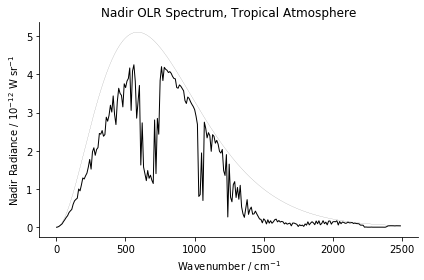

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(frequency2wavenumber(ws.f_grid.value)/100, ws.y.value / 1e-12, color="black", linewidth=1)
ax1.plot(frequency2wavenumber(ws.f_grid.value)/100, planck(ws.f_grid.value,299.7) / 1e-12, 
                              color="black", linewidth=0.1)

ax1.set_xlabel(r"Wavenumber / cm$^{-1}$")
ax1.set_ylabel(r"Nadir Radiance / 10$^{-12}$ W sr$^{-1}$")

ax1.set_title("Nadir OLR Spectrum, Tropical Atmosphere")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

fig.tight_layout()

fig.savefig("%s.pdf" % (scriptname), bbox_inches='tight')

